# Denoising Autoencoder

VOC dataset, let's add watermark to our data and see if we can define and train an autoencoder to unwatermark the images.

Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as T
from torch import nn
from dataset import VOCCustom
from PIL import Image, ImageOps

(400, 300)


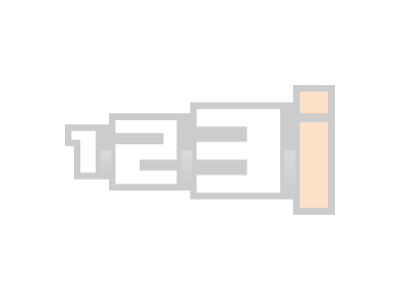

In [2]:
# WATERMARK PARAMETERS
ALPHA_DIV = 4
BORDERS = (65, 85, 65, 85)

# Prepare Watermark
water_mark = Image.open('water_resized_ok.png')
water_mark_b = ImageOps.expand(water_mark, border=BORDERS, fill=0)
print(water_mark_b.size)
wm = water_mark_b.convert("RGBA")
datas = water_mark_b.getdata()
newData = []
for px in datas:
    newData.append((*px[:3], px[3] // ALPHA_DIV))
wm.putdata(newData)
wm
# wm.save('wm_ready.png')

In [3]:
wm = Image.open('wm_ready.png')

In [4]:
# convert data to torch.FloatTensor
def add_watermark(img, wm=wm):
    """
    Adds watermark to an image
    """
    c_img = img.copy()
    c_img.paste(wm, mask=wm)
    return c_img
SIZE = (256, 384)
TRANSFORM_I = T.Compose([T.Resize(SIZE),
                         T.ToTensor()])
TRANSFORM_T = T.Compose([T.Resize(SIZE),
                         add_watermark,
                         T.ToTensor()])
# load the training and test datasets
root_folder = 'D:\DATASETS\VOCDetection'
train_data = VOCCustom(root_folder, img_transform=TRANSFORM_I, target_transform=TRANSFORM_T,
                       image_set='train')
test_data = VOCCustom(root_folder, img_transform=TRANSFORM_I, target_transform=TRANSFORM_T,
                      image_set='val')
# test_data = datasets.VOCDetection(root=root_folder, image_set='val',
#                                    download=True)
# test_data = datasets.ImageNet(root=root_folder, split='val',
#                               download=True, transform=transform)

In [5]:
# how many samples per batch to load
BATCH_SIZE = 16

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

### Visualize the Data

torch.Size([16, 3, 256, 384])


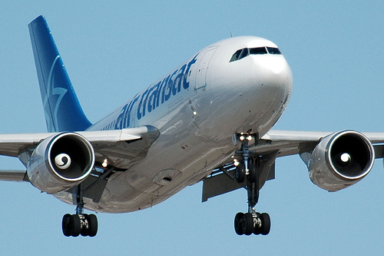

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
img, labels = next(dataiter)
print(img.size())
T.ToPILImage()(img[0])

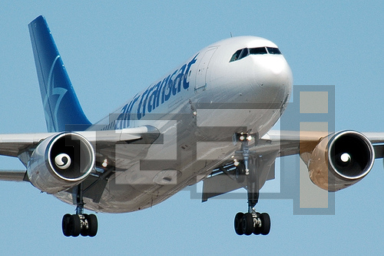

In [7]:
T.ToPILImage()(labels[0])

---
# Removing Watermark

These are the steps taken during traninig:
1. Add the watermark, on the image
    - Remeber to maintain the approximately the same size and aspect.
2. Wartermaked images are used as input and the original, clean images as targets. 


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class encoder_block(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(d_in, d_out, 3, padding=1),
                                   nn.BatchNorm2d(d_out),
                                   nn.LeakyReLU(),
                                   nn.AvgPool2d(2, 2))
    def forward(self, x):
        return self.block(x)
    

class decoder_block(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.block = nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                                   nn.Conv2d(d_in, d_out, 3, padding=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm2d(d_out))
    def forward(self, x):
        return self.block(x)
    

# define the NN architecture
class unWaterMarked(nn.Module):
    def __init__(self, autoenc_depth=[3, 32, 64, 128, 256, 512]):
        super().__init__()
        # ENCODER #
        enc_depth = autoenc_depth
        self.encoder_block_1 = encoder_block(enc_depth[0], enc_depth[1])
        self.encoder_block_2 = encoder_block(enc_depth[1], enc_depth[2])
        self.encoder_block_3 = encoder_block(enc_depth[2], enc_depth[3])
        self.encoder_block_4 = encoder_block(enc_depth[3], enc_depth[4])
        self.encoder_block_5 = encoder_block(enc_depth[4], enc_depth[5])
        # DECODER #
        dec_depth = list(reversed(autoenc_depth))
        self.decoder_block_1 = decoder_block(dec_depth[0], dec_depth[1])
        self.decoder_block_2 = decoder_block(dec_depth[1], dec_depth[2])
        self.decoder_block_3 = decoder_block(dec_depth[2], dec_depth[3])
        self.decoder_block_4 = decoder_block(dec_depth[3], dec_depth[4])
        self.decoder_block_5 = decoder_block(dec_depth[4], dec_depth[5])
        
        # Skipping Conections
        self.encoder_1 = nn.Sequential(self.encoder_block_1, self.encoder_block_2)
        self.encoder_2 = nn.Sequential(self.encoder_block_3, self.encoder_block_4)
        self.encoder_3 = self.encoder_block_5
        
        self.decoder_1 = self.decoder_block_1
        self.decoder_2 = nn.Sequential(self.decoder_block_2, self.decoder_block_3)
        self.decoder_3 = nn.Sequential(self.decoder_block_4, self.decoder_block_5)
        

    def forward(self, x):
        ## encode ##
        e1 = self.encoder_1(x)
        e2 = self.encoder_2(e1)
        e3 = self.encoder_3(e2)
        
        d1 = self.decoder_1(e3)
        d2 = self.decoder_2(d1 + e2)
        d3 = self.decoder_3(d2 + e1)
                
        return d3

In [9]:
# initialize the NN
autoencoder_depth = [3, 32, 64, 128, 256, 512]
model = unWaterMarked(autoencoder_depth)
print(model)

unWaterMarked(
  (encoder_block_1): encoder_block(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (encoder_block_2): encoder_block(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (encoder_block_3): encoder_block(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): AvgPool2d(kernel_size=2, s

---
## Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [10]:
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
# Move model
model = model.to(device)

In [12]:
# PARAMETERS
LR = 0.128
LR_FACTOR = .5
PATIENCE = 2
INIT_EPOCH = 0
EPOCHS = 100

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       'min',
                                                       factor=LR_FACTOR,
                                                       patience=PATIENCE)

In [13]:
from train import Trainer

In [14]:
trainer = Trainer(train_loader, test_loader, model, optimizer, scheduler, criterion)

In [ ]:
trainer.train(n_epochs=EPOCHS, print_every=400)

In [ ]:
from train import find_best_model, load_checkpoint
best_model = find_best_model()
INIT_EPOCH = best_model['epoch']
model, optimizer, scheduler, losses = load_checkpoint(best_model['path'], model,
                                                      optimizer, scheduler, 'cuda')

## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

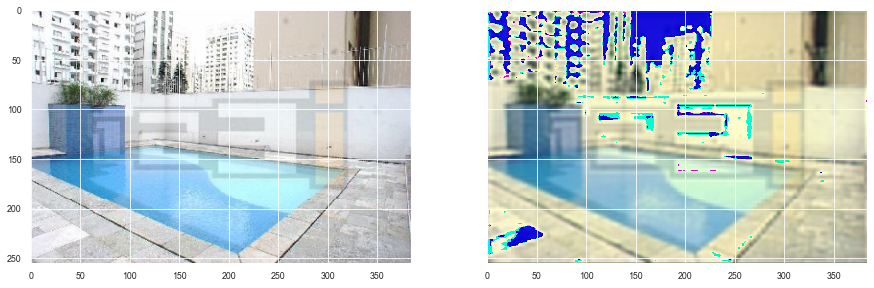

In [53]:
import matplotlib.pyplot as plt
# obtain one batch of test images
test_img = Image.open('test/1.jpg')
test_img  = TRANSFORM_I(test_img)
test_img = test_img.unsqueeze(0)

# get sample outputs
output = model(test_img.to(device))
# prep images for display

# output is resized into a batch of iages
output = output.squeeze()
test_img = test_img.squeeze()
# use detach when it's an output that requires_grad
output = T.ToPILImage()(output.cpu().detach())
img = T.ToPILImage()(test_img.cpu().detach())

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 15))

# input images on top row, reconstructions on bottom
axes[0].imshow(img)
axes[1].imshow(output)
